# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.



## Problem Statement 


The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.

There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.

The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

So in this project, we will use machine learning to predict the response of customers to offers either by "offer received", "offer viewed" or "offer completed". This information will be predicted based on some demographic informatio of the users as well as other purchasing data.


## Import the needed libraries

In [944]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

import seaborn as sns

## Read the data from json files

In [984]:
def Load_datasets(portfolio_file_path, profile_file_path, transcript_file_path):
    """
    This function is used to load the datasets from json files
    
    Input:
    portfolio_file_path -- portfolio dataset file path
    profile_file_path --  profile dataset file path
    transcript_file_path -- transcript dataset file path
    
    Output:
    portfolio -- portfolio dataframe
    profile -- profile dataframe
    transcript -- transcript dataframe
    
    """
    
    # read in the json files
    portfolio = pd.read_json(portfolio_file_path, orient='records', lines=True) #'data/portfolio.json'
    profile = pd.read_json(profile_file_path, orient='records', lines=True) #'data/profile.json'
    transcript = pd.read_json(transcript_file_path, orient='records', lines=True) #'data/transcript.json'
    
    return portfolio, profile, transcript

## Data Preparation and Cleaning

This section contains all the functions needed to clean and transform the datasets

**1- Portfolio dataset**

Offers sent during 30-day test period (10 offers x 6 fields)
* reward: (numeric) money awarded for the amount spent
* channels: (list) web, email, mobile, social
* difficulty: (numeric) money required to be spent to receive reward
* duration: (numeric) time for offer to be open, in days
* offer_type: (string) type of offer: bogo, discount, informational
* id: (string/hash)

There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. 
- In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. 
- In a discount, a user gains a reward equal to a fraction of the amount spent. 
- In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. 

Offers can be delivered via multiple channels.


In [985]:
def clean_portfolio(portfolio):
    """
    This function cleans the portfolio dataset by filling the missing values 
    and convert any string column into numeric by One hot encoding
    
    Input:
    portfolio -- portfolio dataset
    
    Output:
    portfolio dataset cleaned
    
    """
    
    portfolio_cleaned = portfolio.copy()
    # make channels separate columns and make them numeric (One hot encoding)
    channels = []
    for lst in portfolio_cleaned['channels']:
        channels.extend(lst)

    df_exploded = portfolio_cleaned.explode('channels')
    df_exploded['_helper'] = 1
    df_wide = df_exploded.pivot(index='id', columns='channels', values='_helper')
    df_wide = df_wide.fillna(0)

    portfolio_cleaned = portfolio_cleaned.merge(df_wide, how='inner', on='id')
    
    portfolio_cleaned = portfolio_cleaned.drop('channels', axis=1)
    
    
    # Make offer type numeric (One hot encoding)
    offer_types = pd.get_dummies(portfolio_cleaned.offer_type, dtype='int64')

    portfolio_cleaned = pd.concat([portfolio_cleaned,offer_types], axis=1)
#     portfolio = portfolio.drop('offer_type', axis=1)

    
    # Rename reward columns
    portfolio_cleaned = portfolio_cleaned.rename(columns = {'reward':'reward_offer'})
    
    return portfolio_cleaned


**2- Profile Dataset**

Rewards program users (17000 users x 5 fields)
* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* became_member_on: (date) format YYYYMMDD
* income: (numeric)


In [986]:
def clean_profile(profile):
    """
    This function cleans the profile dataset by filling the missing values 
    and convert any string column into numeric by One hot encoding
    
    Input:
    profile -- profile dataset
    
    Output:
    profile dataset cleaned
    
    
    """
    
    # Fill nulls
    
#     We can see that records with missing values have missing the three columns: age, gender and income!!
#     For income column, we can fill the nul with the mean. While the Gender column, we can fill with forward fill

    profile_cleaned = profile.copy()
    mean_income = profile_cleaned['income'].mean()
    profile_cleaned['income'] = profile_cleaned['income'].fillna(mean_income)
#     profile_cleaned.isnull().sum()


    # replace gender with the most common appearing value
    mode_gender = profile_cleaned['gender'].mode()[0]
    profile_cleaned['gender'] = profile_cleaned['gender'].fillna(mode_gender)
    
    # Make Gender numeric (One hot encoding)
    le = preprocessing.LabelEncoder()
    le.fit(profile_cleaned['gender'])
#     print(le.classes_)
    profile_cleaned['gender'] = le.transform(profile_cleaned['gender'])

    
    
#     We can see that records with missing values have missing the three columns: age, gender and income!!
# For income column, we can fill the nul with the mean. While the Gender column, we can fill with forward fill
    
    return profile_cleaned


**3- Transcript Dataset**

Event log (306648 events x 4 fields)
* person: (string/hash)
* event: (string) offer received, offer viewed, transaction, offer completed
* value: (dictionary) different values depending on event type
    * offer id: (string/hash) not associated with any "transaction"
    * amount: (numeric) money spent in "transaction"
    * reward: (numeric) money gained from "offer completed"
* time: (numeric) hours after start of test

In [987]:
def clean_transcript(transcript):
    """
    This function cleans the transcript dataset by filling the missing values 
    and convert any string column into numeric by One hot encoding.
    In addition, it adds some information like the counts and sum of transcations amounts.
    
    Input:
    transcript -- transcript dataset
    
    Output:
    transcript dataset cleaned
    
    """
    
    # Extract the data contained in dictionary column "value"
    transcript_cleaned = transcript.copy()
    transcript_cleaned['offer id'] = transcript_cleaned['value'].apply(lambda x: x.get('offer id') if x.get('offer id') else x.get('offer_id'))
    transcript_cleaned['amount'] = transcript_cleaned['value'].apply(lambda x: x.get('amount'))
    transcript_cleaned['reward'] = transcript_cleaned['value'].apply(lambda x: x.get('reward'))
    transcript_cleaned = transcript_cleaned.drop(['value'], axis=1)
    
    
    # calculate count of transactions performed by the user then remove transactions not related to offers
    count_transactions = pd.DataFrame(transcript_cleaned.groupby('person')['amount'].count()).reset_index()
    count_transactions.columns = ['person', 'Count_Transactions']
    Sum_transactions = pd.DataFrame(transcript_cleaned.groupby('person')['amount'].sum()).reset_index()
    Sum_transactions.columns = ['person', 'total_amount_spent']

    transcript_cleaned = transcript_cleaned.merge(count_transactions, how='inner', on='person')
    transcript_cleaned = transcript_cleaned.merge(Sum_transactions, how='inner', on='person')

#     transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f'] #9fa9ae8f57894cc9a3b8a9bbe0fc1b2f
    
    # Fill Nan values
    transcript_cleaned = transcript_cleaned.rename(columns = {'reward':'reward_transaction'})
    
    transcript_cleaned['reward_transaction'] = transcript_cleaned['reward_transaction'].fillna(0)
    transcript_cleaned['amount'] = transcript_cleaned['amount'].fillna(0)
    
# From this exploration, we can see that records with "Offer received" and "Offer Viwed" has "offer ID" while records with "Transacion" have "amount" and finally records with "offer completed" have "reward"    
    
    return transcript_cleaned


### Make a new combined dataset with all the information

In [988]:
def transform_merge_all_datasets(portfolio_cleaned, profile_cleaned, transcript_cleaned):
    """
    This function is used to make a new combined dataset with all the information
    Also, it adds some information like the counts of offers ('bogo_counts', 'discount_counts', 'informational_counts')
    
    Input:
    portfolio_cleaned -- portfolio dataset after being cleaned
    profile_cleaned -- profile  dataset after being cleaned
    transcript_cleaned -- transcript  dataset after being cleaned
    
    
    Output:
    df -- combine or merged dataframe
    
    """
    

    # Merge aall datasets into one dataset

    df = transcript_cleaned.merge(portfolio_cleaned, how = 'inner', left_on='offer id', right_on = 'id')
    # inner join to drop transactions rows
    df = df.drop('id', axis=1)

    df = df.merge(profile_cleaned, how = 'inner', left_on='person', right_on = 'id')
    df = df.drop('id', axis=1)

    offer_counts_df = pd.DataFrame(df.groupby(['person','event'])['offer id'].count().unstack()).reset_index()
    
    offer_type_df = pd.DataFrame(df.groupby(['person','offer_type'])['offer id'].count().unstack()).reset_index()
    
    counts_df = offer_type_df.merge(offer_type_df, how='inner', on='person')

    counts_df.columns = ['person', 'bogo_counts', 'discount_counts', 'informational_counts', 'bogo_y',
       'discount_y', 'informational_y']
    
    df = df.merge(counts_df, how='inner', on='person')
    
    df = df.drop('offer_type', axis=1)

    df.drop(list(df.filter(regex='_y$')), axis=1, inplace=True)
    
#     df.columns = df.columns.str.replace('_x','')
    
    df['bogo_counts'] = df['bogo_counts'].fillna(0)
    df['discount_counts'] = df['discount_counts'].fillna(0)
    df['informational_counts'] = df['informational_counts'].fillna(0)


    return df

## Data Exploration and Understanding

Befor exploring the data and make some observations, we will load and clean the datasets using the previously created functions.

In [989]:
portfolio, profile, transcript = Load_datasets('data/portfolio.json', 'data/profile.json', 'data/transcript.json')
portfolio_cleaned = clean_portfolio(portfolio)
profile_cleaned = clean_profile(profile)
transcript_cleaned = clean_transcript(transcript)


#### What are the available offers and their types?

,offer_type,count
0,bogo,4
1,discount,4
2,informational,2


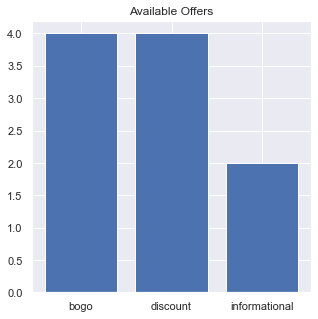

In [990]:
#check portoflio type counts

count_by_offertype = portfolio.groupby('offer_type')['id'].count()
count_by_offertype = pd.DataFrame(count_by_offertype).reset_index()
# count_by_offertype
count_by_offertype.columns = ['offer_type', 'count']

# count_by_offertype.hist()#x=count_by_offertype['offer_type'] , y=count_by_offertype['count'])
plt.bar(x=count_by_offertype['offer_type'] , height=count_by_offertype['count'])
plt.title('Available Offers')
count_by_offertype

This dataset has 4 offers wth bogo and 4 with discount and 2 informational



#### What are the Purchasing types of customers and their counts?

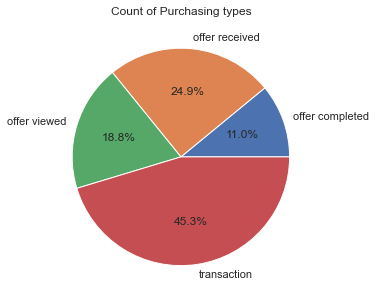

In [991]:
## What are the events?
events = transcript['event'].unique()
# print(events)

Num_events = transcript.groupby('event')['person'].count().reset_index()
Num_events.columns = ['event', 'count']
plt.pie(Num_events['count'], labels = Num_events['event'],autopct='%1.1f%%')
plt.title('Count of Purchasing types');

We can see that the transaction records have the biggest number because not all transactions are related to offers. There are a lot of transactions done by people without receiving an offer or maybe after receiving an offer but not using it due to the minimum amount needed to redeem the offer for example.


#### What are the most purchased type of offer?

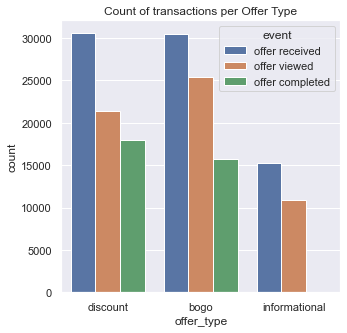

In [992]:
# Count offer transactions
completed_offers = transcript_cleaned.merge(portfolio, how='inner', left_on='offer id', right_on='id')
completed_offers = completed_offers[['person', 'event', 'offer id', 'offer_type']]

count_completed_offers = completed_offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
count_completed_offers.columns = ['event', 'offer_type','count']
count_completed_offers = count_completed_offers.append({'event':'offer completed','offer_type': 'informational', 'count':0}, ignore_index=True)
# count_completed_offers

# Plot
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(x = 'offer_type', 
            y = 'count',
            hue = 'event',
            data = count_completed_offers.sort_values(by='count', ascending=False)).set_title('Count of transactions per Offer Type');




We can see from the above chart that "Dicount" offer has the biggest Completed offer number which means that people like discount offers more than bogo.
Also, an obvious observation that the number of received offer is greater than the viewed one which is greater than the completed one because not all offers sent to customers are redeemed in real life.

#### Let's explore the customers data

#### Age distribution of customers

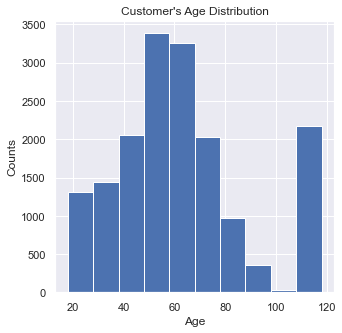

In [993]:
profile.age.hist()
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title("Customer's Age Distribution");

#### Gender distribution of customers

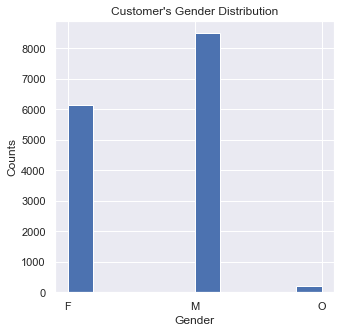

In [994]:
profile.gender.hist()
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title("Customer's Gender Distribution");

#### Income distribution of customers

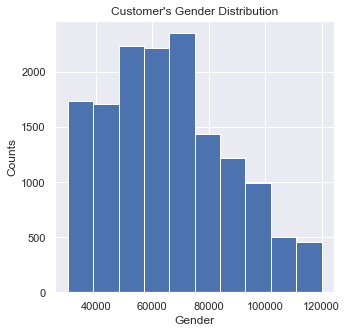

In [995]:
profile.income.hist()
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title("Customer's Gender Distribution");

## Data Modeling and Evaluation

This part is used to create a machine learning model and predict the purchasing level of offers

In [1038]:
def build_model(classifier='Random Forest'):
    """
    This function splits the data into training and test sets and fit the model.
    into this data. There are 3 versions of building the model:
    1- Using Random Forest classifier
    2- Using Decision Tree classifier
    3- Using K Neareset Neighbor classifier
    
    Input:
    classifier -- takes one of 3 inputs 'Random Forest', 'Decision Tree' or 'KNN'
    
    Output:
    model fitted
    
    """
    if classifier == 'Random Forest':
        pipeline = Pipeline([
            ('classifier', RandomForestClassifier())
        ])
        
        parameters = {
            'classifier__n_estimators': (1, 4, 5, 10),
            'classifier__max_depth': (5, 10)
        }

    elif classifier == 'Decision Tree':
        pipeline = Pipeline([
            ('classifier', DecisionTreeClassifier())
        ])

        parameters = {
            'classifier__max_depth': [None, 5, 10]
        }
        
    elif classifier == 'KNN':
        pipeline = Pipeline([
            ('classifier', KNeighborsClassifier())
        ])

        parameters = {    
            'classifier__n_jobs': [1, 3, 5],
            'classifier__n_neighbors': [5, 7, 10]

        }
            

    cv = GridSearchCV(pipeline, param_grid=parameters)

    
    return cv


def evaluate_model(model, X_test, y_test, category_names):
    """
    This function uses the ML model to predict the output of any new data given and prints the classification result report as Precision, Recall and F1-score
    and prints the results of prediction as classification report, confusion matrix and accuracy.
    
    Input:
    model -- ML model or classifier
    X_test -- The testing data
    Y_test -- the correct result of testing data
    category_names -- classes names
    
    Output:
    None
    """
    y_pred = model.predict(X_test)
#     y_pred.columns = category_names
    
    print("The target value counts")
#     for i in set(y_pred):
#         print(y_pred.count(i)
    print(pd.DataFrame({'Target Value':category_names, 'Counts':np.unique(list(y_pred), return_counts=True)[1]}))
    
    print('\n classification report \n')
    print(classification_report(y_test,y_pred, target_names=category_names))
    print('\n confusion matrix \n')
    print(confusion_matrix(y_test,y_pred))
    print('\n Accuracy \n')
    print(accuracy_score(y_test,y_pred))
    print('\n Model F1 Score \n')
    print(model.score(X_test, y_test))




In [1039]:
def main(classifier='Random Forest'):
    
    portfolio, profile, transcript = Load_datasets('data/portfolio.json', 'data/profile.json', 'data/transcript.json')

    portfolio_cleaned = clean_portfolio(portfolio)
#     portfolio_cleaned.head()

    profile_cleaned = clean_profile(profile)
#     profile_cleaned.head()

    transcript_cleaned = clean_transcript(transcript)
#     transcript_cleaned.head()

    df = transform_merge_all_datasets(portfolio_cleaned, profile_cleaned, transcript_cleaned)
#     df.head()

    ## Build Features and Target vectors
    X = df[['time', 'amount', 'reward_transaction',
           'Count_Transactions', 'total_amount_spent', 'reward_offer',
           'difficulty', 'duration', 'email', 'mobile', 'social',
           'web', 'gender', 'age', 'became_member_on', 'income', 'bogo_counts',
           'discount_counts', 'informational_counts', 'bogo', 'discount',
           'informational']]
    y = df['event']


    # Use one hot encoder to encode target value
    le = preprocessing.LabelEncoder()
    le.fit(y)
#     print(list(le.classes_))
    y = le.transform(y)

    category_names = list(le.classes_)

    ### Split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    classifier = build_model(classifier)

    classifier.fit(X_train, y_train)
    
    print("The best parameters for this classifier are: \n")
    print(classifier.best_params_)
    

    evaluate_model(classifier, X_test, y_test, category_names)
    
    print("\n ---------------------------------------------------------------- \n")

In [1040]:

classifiers = ['Random Forest', 'KNN', 'Decision Tree']

for classifier in classifiers:
    print("Using classifier " + classifier +': \n')
    main(classifier='Random Forest')


Using classifier Random Forest: 

The best parameters for this classifier are: 

{'classifier__max_depth': 10, 'classifier__n_estimators': 10}
The target value counts
      Target Value  Counts
0  offer completed    6643
1   offer received   23595
2     offer viewed    3279

 classification report 

                 precision    recall  f1-score   support

offer completed       1.00      1.00      1.00      6643
 offer received       0.64      0.99      0.78     15258
   offer viewed       0.97      0.27      0.43     11616

       accuracy                           0.75     33517
      macro avg       0.87      0.76      0.74     33517
   weighted avg       0.83      0.75      0.70     33517


 confusion matrix 

[[ 6643     0     0]
 [    0 15169    89]
 [    0  8426  3190]]

 Accuracy 

0.7459498165110242

 Model F1 Score 

0.7459498165110242

 ---------------------------------------------------------------- 

Using classifier KNN: 

The best parameters for this classifier are: 

{'

## Conclusion

In this project, the machine learning model was run with 3 version:
* Random Forest
* K Nearest Neighbors
* Decision Tree

We can see that the three models perform almost the same with an accuracy between 74 ad 76% which is acceptable.

There is one comment on data imbalance as most of the "offers" have purchasing type "offer received" and not "viewed" or "completed" as shown in the above tables of the counts of predicted target values from all models so most of the events are predicted as "offer received" because "offer received" is the most occuring event.

